<a href="https://colab.research.google.com/github/isatyamks/jax-flax-llm-examples/blob/main/notebooks/modelV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# !pip install -q jax-ai-stack
# !pip install -Uq tiktoken grain matplotlib
# !pip install grain


# !pip install tiktoken

In [38]:
# import jax
# jax.devices()

In [39]:
# !wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

In [40]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
import optax
from dataclasses import dataclass
import grain.python as pygrain
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import pandas as pd
import tiktoken
import time

In [41]:
mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

In [42]:
tokenizer = tiktoken.get_encoding("gpt2")

In [43]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, *, rngs: nnx.Rngs, rate: float = 0.1):
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                          rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=rate)
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                         rngs=rngs)
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        self.dropout2 = nnx.Dropout(rate=rate)
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P(None, 'model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                         rngs=rngs)


    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        _, seq_len, _ = input_shape

        # Create causal mask
        mask = causal_attention_mask(seq_len)

        # Apply MultiHeadAttention with causal mask
        attention_output = self.mha(
            inputs_q=inputs,
            mask=mask,
            decode=False
        )
        attention_output = self.dropout1(attention_output, deterministic=not training)
        out1 = self.layer_norm1(inputs + attention_output)

        # Feed-forward network
        ffn_output = self.linear1(out1)
        ffn_output = nnx.relu(ffn_output)
        ffn_output = self.linear2(ffn_output)
        ffn_output = self.dropout2(ffn_output, deterministic=not training)

        return self.layer_norm2(out1 + ffn_output)


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, *, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=maxlen, features=embed_dim, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return token_embedding + position_embedding


class MiniGPT(nnx.Module):
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(
                    maxlen, vocab_size, embed_dim, rngs=rngs
                )
        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs
        ) for _ in range(num_transformer_blocks)]

        self.output_layer = nnx.Linear(in_features=embed_dim,
                                       out_features=vocab_size,
                                       kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                       bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                       rngs=rngs)

    def __call__(self, inputs, training: bool = False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        outputs = self.output_layer(x)
        return outputs

    def generate_text(self, max_tokens: int, start_tokens: [int], top_k=10):
        def sample_from(logits):
            logits, indices = jax.lax.top_k(logits, k=top_k)
            logits = nnx.softmax(logits)
            return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

        def generate_step(start_tokens):
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = jnp.array(start_tokens[:maxlen])
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = jnp.array(start_tokens + [0] * pad_len)
            else:
                x = jnp.array(start_tokens)

            x = x[None, :]
            logits = self(x)
            next_token = sample_from(logits[0][sample_index])
            return next_token

        generated = []
        for _ in range(max_tokens):
            next_token = generate_step(start_tokens + generated)
            # Truncate whatever is after '<|endoftext|>' (stop word)
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              break
            generated.append(int(next_token))
        return tokenizer.decode(start_tokens + generated)

def create_model(rngs):
    return MiniGPT(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks=4, rngs=rngs)

In [44]:
vocab_size = tokenizer.n_vocab
num_transformer_blocks = 8
maxlen = 256
embed_dim = 256
num_heads = 8
feed_forward_dim = 256
batch_size = 256 # You can set a bigger batch size if using Kaggle TPU
num_epochs = 1

In [45]:
@dataclass
class TextDataset:
    data: list
    maxlen: int

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Use Tiktoken for tokenization
        encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]  # Tokenize and truncate
        return encoding + [0] * (self.maxlen - len(encoding))  # Pad to maxlen

def load_and_preprocess_data(file_path, batch_size, maxlen):

    with open(file_path, 'r') as f:
      text = f.read()

    stories = text.split('<|endoftext|>')
    stories = [story+'<|endoftext|>' for story in stories if story.strip()]
    df = pd.DataFrame({'text': stories})
    data = df['text'].dropna().tolist()
    dataset = TextDataset(data, maxlen)

    sampler = pygrain.IndexSampler(
        len(dataset),
        shuffle=False,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=num_epochs,
    )

    dl = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
    )

    return dl

text_dl = load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen)

In [46]:
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: MiniGPT, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

In [ ]:
model = create_model(rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)
rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:maxlen]
generated_text = model.generate_text(
    maxlen, start_tokens
)
print(f"Initial generated text:\n{generated_text}\n")


metrics_history = {
  'train_loss': [],
}

prep_target_batch = jax.vmap(lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0]))))

step = 0
for epoch in range(num_epochs):
    start_time = time.time()
    for batch in text_dl:
        if len(batch) % len(jax.devices()) != 0:
          continue  # skip the remaining elements
        input_batch = jnp.array(jnp.array(batch).T)
        target_batch = prep_target_batch(input_batch)
        train_step(model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

        if (step + 1) % 200 == 0:
          for metric, value in metrics.compute().items():
              metrics_history[f'train_{metric}'].append(value)
          metrics.reset()

          elapsed_time = time.time() - start_time
          print(f"Step {step + 1}, Loss: {metrics_history['train_loss'][-1]}, Elapsed Time: {elapsed_time:.2f} seconds")
          start_time = time.time()

          generated_text = model.generate_text(
              maxlen, start_tokens
          )
          print(f"Generated text:\n{generated_text}\n")
        step += 1

# Final text generation
generated_text = model.generate_text(
    maxlen, start_tokens
)
print(f"Final generated text:\n{generated_text}")

Initial generated text:
Once upon a timeaciaGender gearuser Analysisval {} Bruce Lauren helic Lauren Bruce againstliterally SQU retire Path {}valascript northwest {} Bruceuit Pathascript northwestdrops freelyvic996 curated hysteria FS psychedelic {}ligaval {} perished {} Woman {} {} inflicwaves Analysis996 servants Bruce Charlotte dissatisfiedascript Whites retire {} retire {} perished Schools {}Nick sorrow psychedelicfingerelaide {} perished Blackburnrestyy elder swing interesting Tang Shattered {} {}scl less abnorm abnorm Goldmancre motions fleshthird fatal haw {} perished {} Dani Whites {} Whites retire {} sorrowolate Whites {} Womanlast doom appendixfinger {}Rain pressurefinger {} {} Womanorem Bruce simplyrest {} {} inexplicablerest HS Charlotte dissatisfied stranger perished Tang reassUV {} Abortion outragedaligned {} server fertility decision FSShould {} {} northwestroid variable {} Whites {} dancersithmetic {} {} Whites las hampered {} Woman {} Woman {} Mineundrum {} inexplicabl

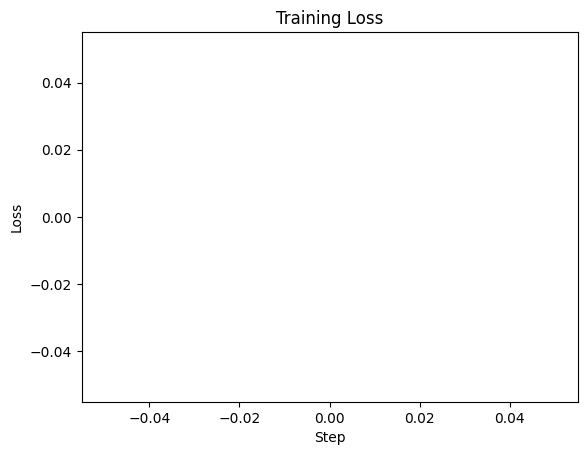

In [34]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [ ]:
import eqx
import cloudpickle
import os

# Define file paths for saving the model and metadata.
checkpoint_file = os.path.join("checkpoints", "model.eqx")
checkpoint_params_file = os.path.join("checkpoints", "params.pkl")

# Ensure the checkpoint directory exists.
os.makedirs("checkpoints", exist_ok=True)

# Save the model using Equinox’s tree serialization.
eqx.tree_serialise_leaves(checkpoint_file, model)

# Save additional parameters (like training step, learning rate, etc.) in a dictionary.
checkpoint_params = {
    "iter_num": step,
    "train_loss": metrics_history['train_loss'][-1] if metrics_history['train_loss'] else None,
    # You can add other parameters like optimizer state or config if needed.
}

with open(checkpoint_params_file, "wb") as f:
    cloudpickle.dump(checkpoint_params, f)
